This notebook allows you to train the SVM model for the catheterization prediction model presented here: https://ecs193-final-project.herokuapp.com/svm_cath_page. You will need to download some already-cleaned data, found here: https://drive.google.com/file/d/1l0goZMgERAVSj7BMYumerYLdDvZG-jh0/view?usp=sharing

In [0]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline

In [0]:
patient_data = pd.read_csv("CleanData.csv")

In [14]:
patient_data.head(10)

,Unnamed: 0,UCDID,Age,RiskRecentSmoker,ACCHxHypertension,ACCHxHypercholesterol,ACCFamilyHxCAD,RiskPriorMI,ACCCHF,ACCValvularSurgery,ACCPrevCoroIntervention,HeightCM,WeightKG,ACCHxKidneyFailure,ACCCerebroVascDisease,ACCPeripheralVascDisease,ACCHxChronicLungDisease,DiabetesHistory,DiabetesTherapy,StudyStressSPECTMRIResult,StudyStressSPECTMRIIschemia,ProcedureDiagnostic,PCIProcedure,Scheduling_Type,PostDiagRxRecommendation,CoronaryDominance,LeftMainStenosisNA,ProcOutcomesLMStenosis,ProxLADStenosisNA,ProcOutcomesLADStenosis,MidDistLADStenosisNA,ProcOutcomesLADDistStenosis,CircStenosisNA,ProcOutcomesCIRCStenosis,RCAStenosisNA,ProcOutcomesRCAStenosis,RamusStenosisNA,ProxLADGraftStenosisNA,MidDistLADGraftStenosisNA,CircGraftStenosisNA,RCAGraftStenosisNA,RamusGraftStenosisNA,Cath_result
0,0,UCD001,64,1,1,1,0,0,0,0,0,175.0,89.0,0,0,0,0,1,1,1,-1,1,0,0,1,2,0,0.000000,0,0.0,0,0.00,0,0.00,0,0.0,1,1,1,1,1,1,0
1,1,UCD002,64,1,1,1,1,1,1,0,1,130.0,81.0,0,1,0,0,1,1,2,2,1,0,0,1,2,0,0.111111,0,0.0,0,0.70,0,0.50,0,0.4,1,1,1,1,1,1,1
2,2,UCD003,66,1,1,0,0,0,0,0,0,175.0,87.6,0,1,0,0,0,-1,2,2,1,1,2,4,1,0,0.000000,0,0.0,0,0.50,0,0.90,0,0.0,1,1,1,1,1,1,1
3,3,UCD004,63,0,1,1,0,0,1,0,0,188.0,71.0,0,0,0,0,0,-1,1,-1,1,0,2,1,2,0,0.000000,0,0.0,0,0.00,0,0.00,0,0.0,1,1,1,1,1,1,0
4,4,UCD005,63,0,1,1,0,0,0,0,0,170.0,106.5,0,0,1,0,0,-1,2,2,1,0,0,1,2,0,0.000000,0,0.0,0,0.00,0,0.20,0,0.2,1,1,1,1,1,1,0
5,5,UCD006,66,0,0,0,0,0,0,0,1,163.1,66.0,0,0,0,0,0,-1,2,3,1,0,2,1,2,0,0.000000,0,0.3,0,0.99,0,0.40,0,0.0,1,1,1,1,1,1,1
6,6,UCD007,81,0,0,0,1,0,1,0,0,183.0,68.9,0,0,1,0,0,-1,2,1,1,0,2,1,2,0,0.000000,0,0.0,0,0.30,0,0.60,0,0.4,1,1,1,1,0,1,0
7,7,UCD008,69,0,1,1,0,1,0,0,1,157.0,72.0,1,1,0,0,1,1,2,1,1,1,2,4,1,0,0.000000,0,0.0,0,1.00,0,0.90,0,0.4,0,1,1,1,1,1,1
8,8,UCD009,69,0,1,1,0,1,0,0,1,160.0,73.5,1,0,0,0,1,1,2,2,0,1,-1,-1,-1,1,-1.000000,1,-1.0,1,-1.00,0,0.99,1,-1.0,1,0,0,0,0,0,1
9,9,UCD010,61,1,1,0,0,0,0,0,0,180.1,75.0,0,0,0,0,0,-1,0,-1,1,0,2,1,2,0,0.555556,0,0.3,0,0.60,0,0.50,0,1.0,1,0,0,0,0,0,1


In [0]:
patient_X = patient_data.drop(columns=['Cath_result', 'UCDID', 'Unnamed: 0'])
patient_y = patient_data['Cath_result']

In [0]:
def process_patient_data(patient_X): # patient_X is a pandas dataframe
  patient_X_new = pd.DataFrame.copy(patient_X) # Deep copy of the dataframe
  
  for index, row in patient_X_new.iterrows():
    row["WeightKG"] = row["WeightKG"] / 100.0
    row["HeightCM"] = row["HeightCM"] / 100.0
    row["Age"] = row["Age"] / 100.0
  
  return patient_X_new

In [0]:
patient_X_cleaned = patient_X.to_numpy().astype('float')
patient_y_cleaned = patient_y.to_numpy().astype('float')

In [0]:
def basic_accuracy_metric(y_pred, y_truth):
  count = 0
  for i in range(len(y_pred)):
    if y_pred[i] == y_truth[i]:
      count = count + 1
  return count / len(y_pred)

We train the model across a K fold set and verify the results across the entire K fold.

In [29]:
from sklearn.model_selection import KFold
num_indices = len(patient_X_cleaned[:, 0])
indices = [x for x in range(num_indices)]
kf = KFold(n_splits=10, random_state=None)
total_accuracy = 0

for train_index, test_index in kf.split(indices):
  # split the data
  patient_X_train, patient_X_test = patient_X_cleaned[train_index], patient_X_cleaned[test_index]
  patient_y_train, patient_y_test = patient_y_cleaned[train_index], patient_y_cleaned[test_index]
  # initialize and train model
  svclassifier = SVC(kernel="linear")
  svclassifier.fit(patient_X_train, patient_y_train)
  patient_y_pred = svclassifier.predict(patient_X_test)
  basic_accuracy = basic_accuracy_metric(patient_y_pred, patient_y_test)
  print("Basic accuracy: ", basic_accuracy)
  total_accuracy = total_accuracy + basic_accuracy
  print(classification_report(patient_y_test,patient_y_pred))

print("Average accuracy across K-fold: ", total_accuracy / 10.0)

Basic accuracy:  0.9367088607594937
              precision    recall  f1-score   support

         0.0       0.91      0.94      0.92        31
         1.0       0.96      0.94      0.95        48

    accuracy                           0.94        79
   macro avg       0.93      0.94      0.93        79
weighted avg       0.94      0.94      0.94        79

Basic accuracy:  0.9102564102564102
              precision    recall  f1-score   support

         0.0       0.89      0.86      0.88        29
         1.0       0.92      0.94      0.93        49

    accuracy                           0.91        78
   macro avg       0.91      0.90      0.90        78
weighted avg       0.91      0.91      0.91        78

Basic accuracy:  0.9358974358974359
              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90        24
         1.0       0.96      0.94      0.95        54

    accuracy                           0.94        78
   macro avg       0

Let's save the model for future use.

In [30]:
filename = 'svm_cath.sav'
joblib.dump(svclassifier, filename)

['svm_cath.sav']

Let's load the model and check accuracy.

In [0]:
loaded_model = joblib.load(filename)

In [32]:
patient_y_pred = loaded_model.predict(patient_X_test)
basic_accuracy = basic_accuracy_metric(patient_y_pred, patient_y_test)
print("Basic accuracy: ", basic_accuracy)

Basic accuracy:  0.9871794871794872


Confusion matrix, without normalization


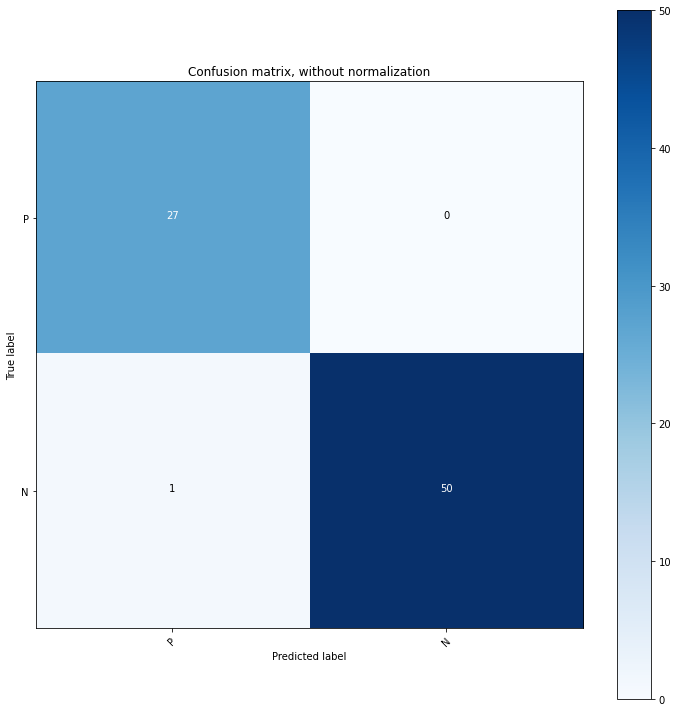

In [33]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
      for j in range (cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(patient_y_test, patient_y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['P', 'N'],
                      title='Confusion matrix, without normalization')
plt.show()